In [1]:
!pip3 install pytorch_pretrained_vit

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch_pretrained_vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11115 sha256=ff2d7242f556014e87970253a40f110650150b8196dbd040f30119baa3ef372a
  Stored in directory: /home/cvmlserver3/.cache/pip/wheels/79/c8/4f/9ad72c6f247a7e6888cc7767db9632675cf82656fffec85518
Successfully built pytorch_pretrained_vit


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn, optim
from pytorch_pretrained_vit import ViT

from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [4]:
#%mkdir ComputerVision
%cd ComputerVision

/home/cvmlserver3/jihee/ComputerVision


In [3]:
# CIFAR-10 데이터셋에 대한 변환 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT는 224x224 입력을 기대
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 데이터셋 다운로드 및 로드
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


# 사전 학습된 ViT 모델 불러오기
model = ViT('B_16', pretrained=True, image_size=224, patches=4)

# CIFAR-10은 10개의 클래스를 가지므로, 마지막 레이어를 수정
model.fc = nn.Linear(model.fc.in_features, 10)

Files already downloaded and verified
Files already downloaded and verified


Downloading: "https://github.com/lukemelas/PyTorch-Pretrained-ViT/releases/download/0.0.2/B_16.pth" to /home/cvmlserver3/.cache/torch/hub/checkpoints/B_16.pth
100%|████████████████████████████████████████████████| 391M/391M [03:45<00:00, 1.82MB/s]


Resized positional embeddings from torch.Size([1, 197, 768]) to torch.Size([1, 197, 768])
Loaded pretrained weights.


In [5]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Multi-GPU 지원을 위해 DataParallel 사용
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# 모델을 GPU로 이동
device = torch.device("cuda")
model.to(device)

DataParallel(
  (module): ViT(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (positional_embedding): PositionalEmbedding1D()
    (transformer): Transformer(
      (blocks): ModuleList(
        (0-11): 12 x Block(
          (attn): MultiHeadedSelfAttention(
            (proj_q): Linear(in_features=768, out_features=768, bias=True)
            (proj_k): Linear(in_features=768, out_features=768, bias=True)
            (proj_v): Linear(in_features=768, out_features=768, bias=True)
            (drop): Dropout(p=0.1, inplace=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (pwff): PositionWiseFeedForward(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
   

In [6]:
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    model.train()
    trainloader_tqdm = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for data in trainloader_tqdm:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm description
        trainloader_tqdm.set_postfix(loss=running_loss / (total / labels.size(0)), accuracy=100 * correct / total)

    train_loss = running_loss / len(trainloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader, desc='Validation', unit='batch'):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(testloader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    end_time = time.time()
    epoch_time = end_time - start_time
    remaining_time = epoch_time * (num_epochs - epoch - 1)
    eta = time.strftime("%H:%M:%S", time.gmtime(remaining_time))

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, '
          f'ETA: {eta}')
    if epoch % 10 == 0:
        # 모델 저장
        torch.save(model.state_dict(), f'vit_cifar10_{epoch}.pth')
        print(f'saved model at epoch {epoch}')

print('Finished Training')

Validation: 100%|████████████████████████████████████| 79/79 [00:18<00:00,  4.29batch/s]


Epoch [1/100], Train Loss: 0.5233, Train Accuracy: 82.91%, Val Loss: 0.3651, Val Accuracy: 87.70%, ETA: 06:33:11
saved model at epoch 0


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  4.00batch/s]


Epoch [2/100], Train Loss: 0.3166, Train Accuracy: 89.46%, Val Loss: 0.3478, Val Accuracy: 88.12%, ETA: 06:48:24


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  3.97batch/s]


Epoch [3/100], Train Loss: 0.2890, Train Accuracy: 90.18%, Val Loss: 0.3769, Val Accuracy: 87.23%, ETA: 06:51:36


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  4.01batch/s]


Epoch [4/100], Train Loss: 0.3070, Train Accuracy: 89.57%, Val Loss: 0.4217, Val Accuracy: 86.45%, ETA: 06:49:07


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  4.04batch/s]


Epoch [5/100], Train Loss: 0.2819, Train Accuracy: 90.29%, Val Loss: 0.3545, Val Accuracy: 88.52%, ETA: 06:46:41


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  4.02batch/s]


Epoch [6/100], Train Loss: 0.3736, Train Accuracy: 87.09%, Val Loss: 0.3832, Val Accuracy: 87.12%, ETA: 06:43:36


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.94batch/s]


Epoch [7/100], Train Loss: 0.2884, Train Accuracy: 90.06%, Val Loss: 0.3823, Val Accuracy: 87.65%, ETA: 06:39:21


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.95batch/s]


Epoch [8/100], Train Loss: 0.3265, Train Accuracy: 88.91%, Val Loss: 0.3993, Val Accuracy: 86.77%, ETA: 06:35:40


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  4.02batch/s]


Epoch [9/100], Train Loss: 0.2560, Train Accuracy: 91.20%, Val Loss: 0.3456, Val Accuracy: 88.39%, ETA: 06:30:35


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.93batch/s]


Epoch [10/100], Train Loss: 0.2354, Train Accuracy: 91.78%, Val Loss: 0.3427, Val Accuracy: 88.95%, ETA: 06:29:56


Validation: 100%|████████████████████████████████████| 79/79 [00:19<00:00,  3.97batch/s]


Epoch [11/100], Train Loss: 0.2704, Train Accuracy: 90.57%, Val Loss: 0.4051, Val Accuracy: 86.58%, ETA: 06:25:22
saved model at epoch 10


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.89batch/s]


Epoch [12/100], Train Loss: 0.2455, Train Accuracy: 91.59%, Val Loss: 0.3614, Val Accuracy: 88.16%, ETA: 06:22:48


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.89batch/s]


Epoch [13/100], Train Loss: 0.2692, Train Accuracy: 90.75%, Val Loss: 0.4202, Val Accuracy: 85.46%, ETA: 06:20:32


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.92batch/s]


Epoch [14/100], Train Loss: 0.2659, Train Accuracy: 90.76%, Val Loss: 0.3206, Val Accuracy: 89.53%, ETA: 06:17:24


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.83batch/s]


Epoch [15/100], Train Loss: 0.2117, Train Accuracy: 92.66%, Val Loss: 0.3337, Val Accuracy: 89.51%, ETA: 06:10:46


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.88batch/s]


Epoch [16/100], Train Loss: 0.1766, Train Accuracy: 93.81%, Val Loss: 0.3457, Val Accuracy: 88.53%, ETA: 06:08:49


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.76batch/s]


Epoch [17/100], Train Loss: 0.1863, Train Accuracy: 93.57%, Val Loss: 0.3419, Val Accuracy: 88.49%, ETA: 06:04:52


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.92batch/s]


Epoch [18/100], Train Loss: 0.1751, Train Accuracy: 93.86%, Val Loss: 0.3369, Val Accuracy: 89.62%, ETA: 05:59:14


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.81batch/s]


Epoch [19/100], Train Loss: 0.1586, Train Accuracy: 94.48%, Val Loss: 0.3739, Val Accuracy: 88.16%, ETA: 05:55:01


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.81batch/s]


Epoch [20/100], Train Loss: 0.1972, Train Accuracy: 93.16%, Val Loss: 0.3675, Val Accuracy: 88.40%, ETA: 05:52:47


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.76batch/s]


Epoch [21/100], Train Loss: 0.1711, Train Accuracy: 94.13%, Val Loss: 0.3251, Val Accuracy: 89.95%, ETA: 05:49:19
saved model at epoch 20


Validation: 100%|████████████████████████████████████| 79/79 [00:20<00:00,  3.83batch/s]


Epoch [22/100], Train Loss: 0.2016, Train Accuracy: 92.95%, Val Loss: 0.3429, Val Accuracy: 89.38%, ETA: 05:49:37


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.72batch/s]


Epoch [23/100], Train Loss: 0.1816, Train Accuracy: 93.64%, Val Loss: 0.3855, Val Accuracy: 88.19%, ETA: 05:43:18


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.75batch/s]


Epoch [24/100], Train Loss: 0.1743, Train Accuracy: 94.03%, Val Loss: 0.3212, Val Accuracy: 89.79%, ETA: 05:41:24


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.67batch/s]


Epoch [25/100], Train Loss: 0.1293, Train Accuracy: 95.49%, Val Loss: 0.3066, Val Accuracy: 90.60%, ETA: 05:38:47


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.69batch/s]


Epoch [26/100], Train Loss: 0.1286, Train Accuracy: 95.58%, Val Loss: 0.3412, Val Accuracy: 89.23%, ETA: 05:36:20


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.69batch/s]


Epoch [27/100], Train Loss: 0.1519, Train Accuracy: 94.68%, Val Loss: 0.3649, Val Accuracy: 88.91%, ETA: 05:38:02


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.63batch/s]


Epoch [28/100], Train Loss: 0.1449, Train Accuracy: 95.00%, Val Loss: 0.3488, Val Accuracy: 89.70%, ETA: 05:42:38


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.64batch/s]


Epoch [29/100], Train Loss: 0.1570, Train Accuracy: 94.58%, Val Loss: 0.3479, Val Accuracy: 89.13%, ETA: 05:40:20


Validation: 100%|████████████████████████████████████| 79/79 [00:22<00:00,  3.57batch/s]


Epoch [30/100], Train Loss: 0.1481, Train Accuracy: 94.76%, Val Loss: 0.3647, Val Accuracy: 89.51%, ETA: 05:39:17


Validation: 100%|████████████████████████████████████| 79/79 [00:22<00:00,  3.56batch/s]


Epoch [31/100], Train Loss: 0.1207, Train Accuracy: 95.81%, Val Loss: 0.3454, Val Accuracy: 90.10%, ETA: 05:41:33
saved model at epoch 30


Validation: 100%|████████████████████████████████████| 79/79 [00:22<00:00,  3.56batch/s]


Epoch [32/100], Train Loss: 0.1308, Train Accuracy: 95.39%, Val Loss: 0.3873, Val Accuracy: 88.24%, ETA: 05:40:23


Validation: 100%|████████████████████████████████████| 79/79 [00:22<00:00,  3.49batch/s]


Epoch [33/100], Train Loss: 0.1623, Train Accuracy: 94.37%, Val Loss: 0.3549, Val Accuracy: 89.24%, ETA: 05:41:13


Validation: 100%|████████████████████████████████████| 79/79 [00:22<00:00,  3.51batch/s]


Epoch [34/100], Train Loss: 0.1141, Train Accuracy: 96.05%, Val Loss: 0.3715, Val Accuracy: 89.53%, ETA: 05:43:23


Validation: 100%|████████████████████████████████████| 79/79 [00:22<00:00,  3.56batch/s]


Epoch [35/100], Train Loss: 0.1577, Train Accuracy: 94.50%, Val Loss: 0.3275, Val Accuracy: 90.39%, ETA: 05:41:47


Validation: 100%|████████████████████████████████████| 79/79 [00:21<00:00,  3.62batch/s]


Epoch [36/100], Train Loss: 0.1474, Train Accuracy: 94.93%, Val Loss: 0.3400, Val Accuracy: 89.57%, ETA: 05:29:22


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.55batch/s]


Epoch [37/100], Train Loss: 0.1590, Train Accuracy: 94.32%, Val Loss: 0.3414, Val Accuracy: 89.27%, ETA: 05:04:25


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.55batch/s]


Epoch [38/100], Train Loss: 0.1172, Train Accuracy: 95.91%, Val Loss: 0.3896, Val Accuracy: 88.80%, ETA: 05:01:03


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.61batch/s]


Epoch [39/100], Train Loss: 0.1399, Train Accuracy: 95.12%, Val Loss: 0.4225, Val Accuracy: 87.17%, ETA: 04:54:18


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.69batch/s]


Epoch [40/100], Train Loss: 0.1621, Train Accuracy: 94.45%, Val Loss: 0.3777, Val Accuracy: 89.14%, ETA: 04:28:29


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.78batch/s]


Epoch [41/100], Train Loss: 0.1530, Train Accuracy: 94.63%, Val Loss: 0.3866, Val Accuracy: 88.71%, ETA: 04:17:32
saved model at epoch 40


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:20<00:00,  3.85batch/s]


Epoch [42/100], Train Loss: 0.0860, Train Accuracy: 97.06%, Val Loss: 0.3757, Val Accuracy: 89.45%, ETA: 04:13:52


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.03batch/s]


Epoch [43/100], Train Loss: 0.1239, Train Accuracy: 95.66%, Val Loss: 0.3646, Val Accuracy: 89.47%, ETA: 04:06:11


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.04batch/s]


Epoch [44/100], Train Loss: 0.1115, Train Accuracy: 96.23%, Val Loss: 0.3668, Val Accuracy: 89.96%, ETA: 03:58:54


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.08batch/s]


Epoch [45/100], Train Loss: 0.1144, Train Accuracy: 96.02%, Val Loss: 0.3907, Val Accuracy: 88.13%, ETA: 03:52:35


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  3.99batch/s]


Epoch [46/100], Train Loss: 0.1198, Train Accuracy: 95.84%, Val Loss: 0.3752, Val Accuracy: 89.32%, ETA: 03:48:09


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.12batch/s]


Epoch [47/100], Train Loss: 0.1299, Train Accuracy: 95.44%, Val Loss: 0.3779, Val Accuracy: 89.47%, ETA: 03:40:31


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.21batch/s]


Epoch [48/100], Train Loss: 0.1779, Train Accuracy: 93.71%, Val Loss: 0.3402, Val Accuracy: 89.56%, ETA: 03:35:20


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.22batch/s]


Epoch [49/100], Train Loss: 0.1667, Train Accuracy: 94.23%, Val Loss: 0.3937, Val Accuracy: 88.70%, ETA: 03:29:00


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.15batch/s]


Epoch [50/100], Train Loss: 0.1379, Train Accuracy: 95.17%, Val Loss: 0.3531, Val Accuracy: 89.44%, ETA: 03:24:42


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.27batch/s]


Epoch [51/100], Train Loss: 0.1214, Train Accuracy: 95.80%, Val Loss: 0.4268, Val Accuracy: 87.39%, ETA: 03:18:55
saved model at epoch 50


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.27batch/s]


Epoch [52/100], Train Loss: 0.1424, Train Accuracy: 95.05%, Val Loss: 0.3598, Val Accuracy: 89.62%, ETA: 03:14:00


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.30batch/s]


Epoch [53/100], Train Loss: 0.2300, Train Accuracy: 92.02%, Val Loss: 0.4632, Val Accuracy: 85.05%, ETA: 03:09:24


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.27batch/s]


Epoch [54/100], Train Loss: 0.2289, Train Accuracy: 91.86%, Val Loss: 0.4082, Val Accuracy: 87.02%, ETA: 03:05:17


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.29batch/s]


Epoch [55/100], Train Loss: 0.1738, Train Accuracy: 94.01%, Val Loss: 0.3382, Val Accuracy: 89.34%, ETA: 03:00:48


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.23batch/s]


Epoch [56/100], Train Loss: 0.2204, Train Accuracy: 92.24%, Val Loss: 0.4987, Val Accuracy: 83.98%, ETA: 02:57:50


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.23batch/s]


Epoch [57/100], Train Loss: 0.2933, Train Accuracy: 89.78%, Val Loss: 0.5728, Val Accuracy: 80.88%, ETA: 02:54:34


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.19batch/s]


Epoch [58/100], Train Loss: 0.3366, Train Accuracy: 88.22%, Val Loss: 0.5846, Val Accuracy: 81.70%, ETA: 02:51:51


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.15batch/s]


Epoch [59/100], Train Loss: 0.3453, Train Accuracy: 87.65%, Val Loss: 0.4427, Val Accuracy: 85.17%, ETA: 02:48:55


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.17batch/s]


Epoch [60/100], Train Loss: 0.2294, Train Accuracy: 91.82%, Val Loss: 0.3755, Val Accuracy: 88.10%, ETA: 02:44:42


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.12batch/s]


Epoch [61/100], Train Loss: 0.2075, Train Accuracy: 92.80%, Val Loss: 0.3903, Val Accuracy: 87.25%, ETA: 02:40:48
saved model at epoch 60


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.24batch/s]


Epoch [62/100], Train Loss: 0.1875, Train Accuracy: 93.26%, Val Loss: 0.4089, Val Accuracy: 87.73%, ETA: 02:37:26


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.07batch/s]


Epoch [63/100], Train Loss: 0.1747, Train Accuracy: 93.82%, Val Loss: 0.4593, Val Accuracy: 85.44%, ETA: 02:34:09


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.08batch/s]


Epoch [64/100], Train Loss: 0.3029, Train Accuracy: 89.37%, Val Loss: 0.4955, Val Accuracy: 83.83%, ETA: 02:30:34


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.03batch/s]


Epoch [65/100], Train Loss: 0.4394, Train Accuracy: 84.55%, Val Loss: 0.4680, Val Accuracy: 84.96%, ETA: 02:25:58


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.18batch/s]


Epoch [66/100], Train Loss: 0.3072, Train Accuracy: 89.24%, Val Loss: 0.5443, Val Accuracy: 81.53%, ETA: 02:21:57


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.17batch/s]


Epoch [67/100], Train Loss: 0.4684, Train Accuracy: 83.52%, Val Loss: 0.6626, Val Accuracy: 77.14%, ETA: 02:16:58


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.08batch/s]


Epoch [68/100], Train Loss: 0.4213, Train Accuracy: 85.08%, Val Loss: 0.4925, Val Accuracy: 84.09%, ETA: 02:13:01


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.12batch/s]


Epoch [69/100], Train Loss: 0.2836, Train Accuracy: 90.00%, Val Loss: 0.4188, Val Accuracy: 86.65%, ETA: 02:08:02


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.08batch/s]


Epoch [70/100], Train Loss: 0.4751, Train Accuracy: 83.53%, Val Loss: 0.4856, Val Accuracy: 83.78%, ETA: 02:03:45


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.16batch/s]


Epoch [71/100], Train Loss: 0.3807, Train Accuracy: 86.68%, Val Loss: 0.5017, Val Accuracy: 83.41%, ETA: 01:59:22
saved model at epoch 70


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.14batch/s]


Epoch [72/100], Train Loss: 0.3833, Train Accuracy: 86.62%, Val Loss: 0.4652, Val Accuracy: 84.79%, ETA: 01:55:32


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:19<00:00,  4.14batch/s]


Epoch [73/100], Train Loss: 0.3960, Train Accuracy: 85.99%, Val Loss: 0.4222, Val Accuracy: 86.07%, ETA: 01:52:11


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.17batch/s]


Epoch [74/100], Train Loss: 0.4342, Train Accuracy: 84.78%, Val Loss: 0.6127, Val Accuracy: 78.79%, ETA: 01:47:12


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.17batch/s]


Epoch [75/100], Train Loss: 0.4520, Train Accuracy: 83.96%, Val Loss: 0.6791, Val Accuracy: 76.99%, ETA: 01:43:29


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.19batch/s]


Epoch [76/100], Train Loss: 0.4285, Train Accuracy: 84.97%, Val Loss: 0.5385, Val Accuracy: 82.33%, ETA: 01:39:02


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.19batch/s]


Epoch [77/100], Train Loss: 0.3935, Train Accuracy: 86.23%, Val Loss: 0.5360, Val Accuracy: 83.09%, ETA: 01:34:31


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.22batch/s]


Epoch [78/100], Train Loss: 0.6297, Train Accuracy: 77.82%, Val Loss: 0.5370, Val Accuracy: 82.02%, ETA: 01:29:49


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.18batch/s]


Epoch [79/100], Train Loss: 0.5093, Train Accuracy: 82.06%, Val Loss: 0.6387, Val Accuracy: 78.31%, ETA: 01:25:56


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.19batch/s]


Epoch [80/100], Train Loss: 0.5445, Train Accuracy: 80.76%, Val Loss: 1.0590, Val Accuracy: 62.51%, ETA: 01:21:26


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.25batch/s]


Epoch [81/100], Train Loss: 0.6222, Train Accuracy: 78.02%, Val Loss: 0.6625, Val Accuracy: 77.48%, ETA: 01:17:24
saved model at epoch 80


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.25batch/s]


Epoch [82/100], Train Loss: 0.5450, Train Accuracy: 80.89%, Val Loss: 0.6661, Val Accuracy: 77.49%, ETA: 01:12:59


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.24batch/s]


Epoch [83/100], Train Loss: 0.4614, Train Accuracy: 83.57%, Val Loss: 0.5420, Val Accuracy: 81.73%, ETA: 01:08:51


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.32batch/s]


Epoch [84/100], Train Loss: 0.4062, Train Accuracy: 85.75%, Val Loss: 0.4913, Val Accuracy: 83.07%, ETA: 01:04:30


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.32batch/s]


Epoch [85/100], Train Loss: 0.5519, Train Accuracy: 80.68%, Val Loss: 0.7231, Val Accuracy: 75.50%, ETA: 01:00:30


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.29batch/s]


Epoch [86/100], Train Loss: 0.5958, Train Accuracy: 78.93%, Val Loss: 0.8675, Val Accuracy: 70.52%, ETA: 00:56:15


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.31batch/s]


Epoch [87/100], Train Loss: 0.6445, Train Accuracy: 77.32%, Val Loss: 0.7822, Val Accuracy: 72.87%, ETA: 00:52:15


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.32batch/s]


Epoch [88/100], Train Loss: 0.6181, Train Accuracy: 78.13%, Val Loss: 0.6156, Val Accuracy: 78.84%, ETA: 00:48:14


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.34batch/s]


Epoch [89/100], Train Loss: 0.8367, Train Accuracy: 70.32%, Val Loss: 0.5261, Val Accuracy: 81.66%, ETA: 00:44:03


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.30batch/s]


Epoch [90/100], Train Loss: 0.5509, Train Accuracy: 80.59%, Val Loss: 0.6350, Val Accuracy: 77.97%, ETA: 00:40:08


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.26batch/s]


Epoch [91/100], Train Loss: 0.5339, Train Accuracy: 81.12%, Val Loss: 0.5540, Val Accuracy: 80.79%, ETA: 00:36:07
saved model at epoch 90


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.31batch/s]


Epoch [92/100], Train Loss: 0.4633, Train Accuracy: 83.67%, Val Loss: 0.5397, Val Accuracy: 81.39%, ETA: 00:32:03


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.28batch/s]


Epoch [93/100], Train Loss: 0.5145, Train Accuracy: 82.06%, Val Loss: 0.7628, Val Accuracy: 73.96%, ETA: 00:28:03


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.33batch/s]


Epoch [94/100], Train Loss: 0.6887, Train Accuracy: 75.63%, Val Loss: 0.8246, Val Accuracy: 71.32%, ETA: 00:24:00


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.29batch/s]


Epoch [95/100], Train Loss: 1.3621, Train Accuracy: 50.90%, Val Loss: 1.0023, Val Accuracy: 64.44%, ETA: 00:19:57


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.32batch/s]


Epoch [96/100], Train Loss: 0.9419, Train Accuracy: 66.59%, Val Loss: 0.8996, Val Accuracy: 68.06%, ETA: 00:15:53


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.32batch/s]


Epoch [97/100], Train Loss: 0.9161, Train Accuracy: 67.66%, Val Loss: 0.7980, Val Accuracy: 72.16%, ETA: 00:11:53


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.31batch/s]


Epoch [98/100], Train Loss: 0.8250, Train Accuracy: 70.88%, Val Loss: 0.7753, Val Accuracy: 73.30%, ETA: 00:07:56


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.28batch/s]


Epoch [99/100], Train Loss: 0.9885, Train Accuracy: 64.79%, Val Loss: 1.2223, Val Accuracy: 56.02%, ETA: 00:03:57


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:18<00:00,  4.34batch/s]

Epoch [100/100], Train Loss: 0.9912, Train Accuracy: 64.74%, Val Loss: 0.9140, Val Accuracy: 67.70%, ETA: 00:00:00
Finished Training


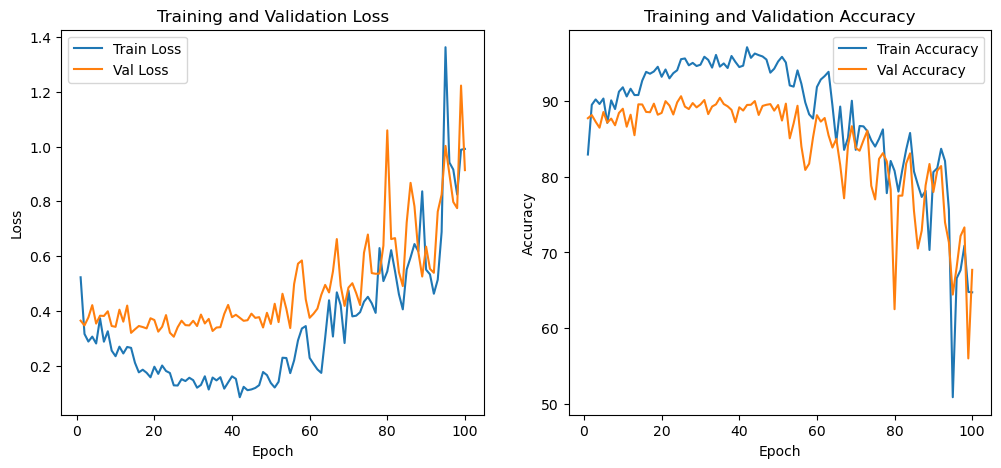

In [7]:
# 모델 저장
torch.save(model.state_dict(), 'vit_cifar10_B_16.pth')

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [8]:
model.eval()
running_test_loss = 0.0
running_test_correct = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        running_test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_test_correct += (preds == labels).sum().item()
        total_test += labels.size(0)

test_loss = running_test_loss / total_test
test_accuracy = running_test_correct / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0072, Test Accuracy: 0.6770


In [1]:
import torch